# Binary Model to Determine Above/Below-ground Pipelines
## From USDA Agriculture Aerial Photographs

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import geopandas as gpd
import matplotlib.pyplot as plt
import ee
import folium
import geemap.core as geemap
import geehydro
import math
import requests
import os
import skimage
import rasterio as rs
import time
from google.cloud import storage
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn import svm, metrics, ensemble
from keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Dropout, Flatten, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.regularizers import l2, l1




In [2]:
def checkdirs(path):
    if not(os.path.exists(path)):
        os.makedirs(path)

In [3]:
def crop(img):
    height, width = img.shape[0:2]
    new = 256

    left = int((width - new)/2)
    top = int((height - new)/2)
    right = int((width + new)/2)
    bottom = int((height + new)/2)

    # print(left,top,right,bottom)
    crop = img[top:bottom,left:right,:]
    print(crop.shape)
    return crop

In [4]:
def getImage(i):
    fname = f"pipeline{i}.tif"
    raw_filename = './images/'+fname
    BUCKET_NAME = 'test_export_bucket0' # change to 'gee_image_exports'
    # put service account key after from_service_account_json() if necessary
    # storage_client = storage.Client.from_service_account_json(r"C:\Users\toliv\Downloads\pipeline-elevation-project-cf69729f47df.json")
    raw_blobname = fname # change to f'USDA_aerials/{raw_filename}'
    checkdirs("./images")

    ## actually grab from cloud storage bucket
    # blob = storage_client.bucket(
#     BUCKET_NAME).blob(raw_blobname)
    blob = storage.Client(project="pipeline-elevation-project").bucket(
    BUCKET_NAME).blob(raw_blobname)
    start = time.time()
    blob.download_to_filename(raw_filename)
    end = time.time()
    print(f"Time taken for download:\n\t{end-start} seconds.")

    raster = rs.open(raw_filename)
    array = raster.read()
    dPic = np.dstack((array[0],array[1],array[2]))
    print(f"Got image {i}\n\twith shape {dPic.shape}")
    print("cropping")
    return crop(dPic)

### Import GeoTIFFs from Google Cloud Storage

In [25]:
## set up reference to GCS
#### should be loop, but for now...
def getImageName(i):
    fname = f"pipeline{i}.tif"
    raw_filename = './images/'+fname

    return raw_filename

#### Giving a simple view to the tiff

In [22]:
raster = rs.open(raw_filename)
array = raster.read()

In [23]:
dPic = np.dstack((array[0],array[1],array[2]))
print(dPic.shape)
print(type(dPic))


(1680, 1464, 3)
<class 'numpy.ndarray'>


## Run this when labeling
### get indices from [here](https://console.cloud.google.com/storage/browser/test_export_bucket0;tab=objects?forceOnBucketsSortingFiltering=true&hl=en&project=pipeline-elevation-project&prefix=&forceOnObjectsSortingFiltering=false)

### make dictionary of labels

In [26]:
labelDict = {}
imgList = []

Time taken for download:
	1.5448715686798096 seconds.
Got image 1002
	with shape (1690, 1448, 3)
cropping
(256, 256, 3)


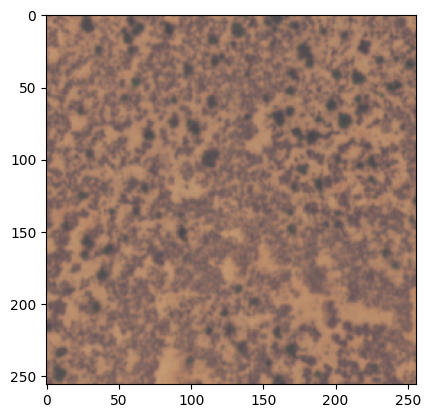

In [38]:
i = 1002
image = getImage(i)
plt.imshow(image)

#### labeling

In [39]:
try:
    labelDict[i]
except KeyError:
    imgList.append(image)
# CHANGE VALUE TO 0 OR 1 BASED ON YOUR DECISION
labelDict[i] = 0 # for example, image 1001 looks pretty green


continue when satisfied with labele

In [ ]:
# might need to make imgList a Numpy Array
# imgArray = np.array(imgList)

In [ ]:
image_df = pd.DataFrame(image.reshape(-1, 3), columns=["Red", "Green", "Blue"])
image_df.head()

In [40]:
veg_prob = [0] * 29933 # length of geojson
labeled = []
for val in labelDict.keys():
    veg_prob[val] = labelDict[val]
    labeled.append(val)
veg_prob = np.array(veg_prob)
known_veg_prob = np.array(veg_prob[labeled])

print(len(veg_prob))
print(len(known_veg_prob))


29933
2


In [41]:
# save labels to csv
import csv
with open("labels.csv",'w',newline='\n') as f:
    wr = csv.writer(f, quoting=csv.QUOTE_ALL)
    for val in labelDict.keys():
        wr.writerow([val,labelDict[val]])

print("done")


done


In [45]:
print(image_df.iloc[:, :3].shape)


(65536, 3)

In [48]:
## also, these don't need to be columns - waste of memory
# you/re setting 
# raw_filename = pd.DataFrame(getImageName(i)) # Do you want the cropped image, the reshaped image, or they varying sizes?
image_df["Vegetation_Probability"] = 0



model = Sequential()
model.add(Dense(128, input_shape=(3,), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(image_df.iloc[:, :3], image_df["Vegetation_Probability"], epochs=10, batch_size=32)

Epoch 1/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9861 - loss: 0.2023
Epoch 2/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 1.0000 - loss: 1.0324e-16
Epoch 3/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 1.0000 - loss: 9.8191e-17
Epoch 4/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 1.0000 - loss: 1.0027e-16
Epoch 5/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 1.0000 - loss: 1.0215e-16
Epoch 6/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 1.0000 - loss: 9.7876e-17
Epoch 7/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 1.0000 - loss: 9.9186e-17
Epoch 8/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 1.0000 - loss: 1.0394e-16
Epoch 9/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 1.0000 - loss: 1.0134e-16
Epoch 10/10
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 1.0000 - loss: 1.0341e-16


### Recommended Convolutional Model

*currently unrun*

In [ ]:
x_train = imgList
y_train = known_veg_prob
x_test = np.array([getImage(1095),getImage(1097),getImage(1098)])
y_test = veg_prob[~labeled]

CVmodel = Sequential([

Conv2D(input_shape=(256,256,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"),
Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"),
Dense(128, input_shape=(3,), activation='relu')
Dense(64, activation='relu')

])
CVmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
CVmodel.fit(x_train, y_train, epochs=10, batch_size=32)

In [15]:
images = []
veg = []

for category in categories:
    folder_path = os.path.join(folder, category)
    image_paths = os.listdir(folder_path)

    for image_path in image_paths:
        image_access = os.path.join(folder_path, image_path)
        image = imageio.imread(image_access)
        image_gray = color.rgb2gray(image)
        images_gray.append(image_gray)
        cats.append(category)

NameError: name 'categories' is not defined

In [16]:
from PIL import Image
from matplotlib import cm
img=getImage(1001)
normImg = img/255
PILIMG = Image.fromarray(np.uint8(normImg)*255)
PILIMG.show()

Time taken for download:
	1.463700294494629 seconds.
Got image 1001
	with shape (1702, 1502, 3)
cropping
(256, 256, 3)


Time taken for download:
	1.6304771900177002 seconds.
Got image 1275
	with shape (1680, 1464, 3)
cropping
(256, 256, 3)


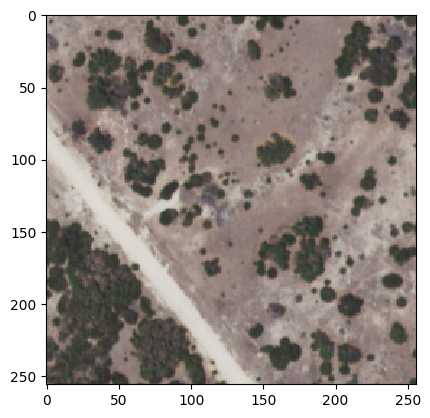

In [ ]:
img=getImage(1005)
#plt.imshow(img)
plt.imshow(getImage(1275), interpolation='nearest')

4 Channels



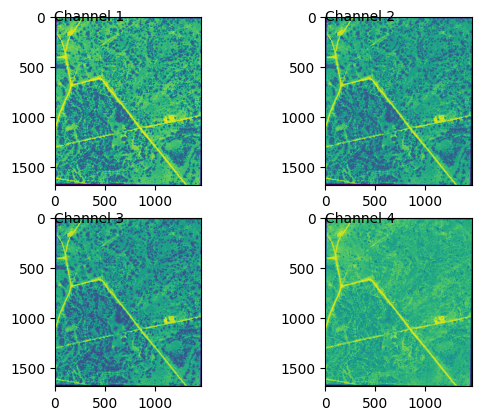

In [ ]:
print(len(array),end=" Channels\n\n")

squareDim = int(math.sqrt(len(array)))
fig, ax = plt.subplots(nrows = squareDim, ncols = squareDim)
for i in range(squareDim):
    for j in range(squareDim):
        ax[i,j].imshow(array[(i*2+j)])
        ax[i,j].text(-5.0,36.0,f"Channel {(i*2+j)+1}")
        
plt.show()


## After finishing operations, close raster

In [ ]:
## untested, might be safe to do after saving rs.read() to variable
rs.close()

AttributeError: module 'rasterio' has no attribute 'close'